The Gaussian Gold Miner

By: Ryan

Problem Statement & Fun Story:

The year is 1852, and California's Gold Rush is at its absolute peak. As a prospective miner, you have recently moved out west to get your fill and strike it rich. Upon arriving in town, you are disheartened to realize that you are one of the last ones to arrive, and therefore you are given one of the worst plots of land to dig on. It is a long, scorching hot ravine that stretches just about a mile. The rocks you will be digging through to find your gold are incredibly tough to break, and each hole you dig takes about a week to finish, at which point you are able to determine the amount of gold in that specific location, and choose whether to dig deeper to collect more of it, or move on to search in a new location.

The initial hole that you dig is 100% predictive of how much gold lies below in that specific region, so if your initial hole contains no gold, digging deeper will still yield nothing, and if that initial hole contains 13 ounces of gold, digging a hole in that exact same spot of the same size just deeper will produce for you another 13 ounces, and so on. Miners call this a "gold pocket".

At sunrise you make the trip out to the ravine with the man who is leasing you the land. He shows you the land you will be mining, as well as two large holes, one at the entrance and one at the exit of the ravine. He says both of these were dug by a pair of miners earlier in the month. The plan had been for each miner to start at a separate end of the ravine, and work their way through until they met in the middle, becoming rich with the gold they found along the way. The only problem was that after a week of digging in the scorching sun, and each miner having only made a single hole, and both the holes having yielded absolutely zero ounces of gold, the pair decided that the ravine wasn't worth the work it took to mine, and packed up to seach elsewhere. Word got out about the difficult plot of land, which is why it was all that was left when you were the last one to show up.

Since this ravine will be incredibly time consuming to mine, you have to find a way to find the location that contains the maximum amount of gold. Once you have found this location, you can dig deeper and deeper in this spot to collect the most gold possible!

Below is a graph that shows the amount of gold per hole dug at each specific area along the one mile ravine. Unfortunately for you, you are not privy to this information. However, we will use it as a reference to see how accurately we are selecting our locations we dig for gold at.

Step 1: Construct a curve that represents gold density per hole dug at every location along our ravine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100


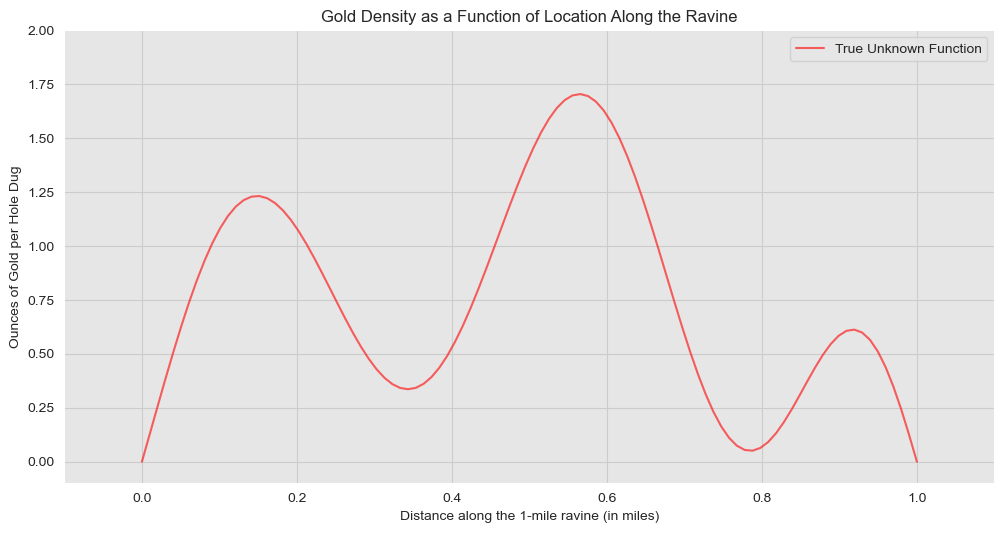

In [3]:

n = 100

x_original = np.linspace(start=0, stop=1, num=n)

def f(x):
    f = np.sin((4*np.pi)*x) + np.sin((3*np.pi)*x**2) + np.sin((np.pi)*x**2)
    return(f)

f_x = f(x_original)

plt.plot(x_original,f_x, color = "red", alpha = 0.6, label='True Unknown Function')
plt.axis([-0.1, 1.1, -0.1, 2])
plt.ylabel('Ounces of Gold per Hole Dug')
plt.xlabel('Distance along the 1-mile ravine (in miles)')
plt.title('Gold Density as a Function of Location Along the Ravine')
plt.legend(loc='upper right')
plt.show()

Step 2:

You begin your first day digging for gold, and decide that you will use a Gaussian Process in order to determine the best locations to mine. In order to do this, you first need a frame of reference to build the Gaussian Process out of. Therefore, you decide to dig 4 holes randomly (but fairly evenly) along the ravine, and use these, along with a Gaussian Process, in order to determine where you should focus your search. It's a months worth of work (one week per hole), but after this, you should be able to have a better idea of where to focus your energy.

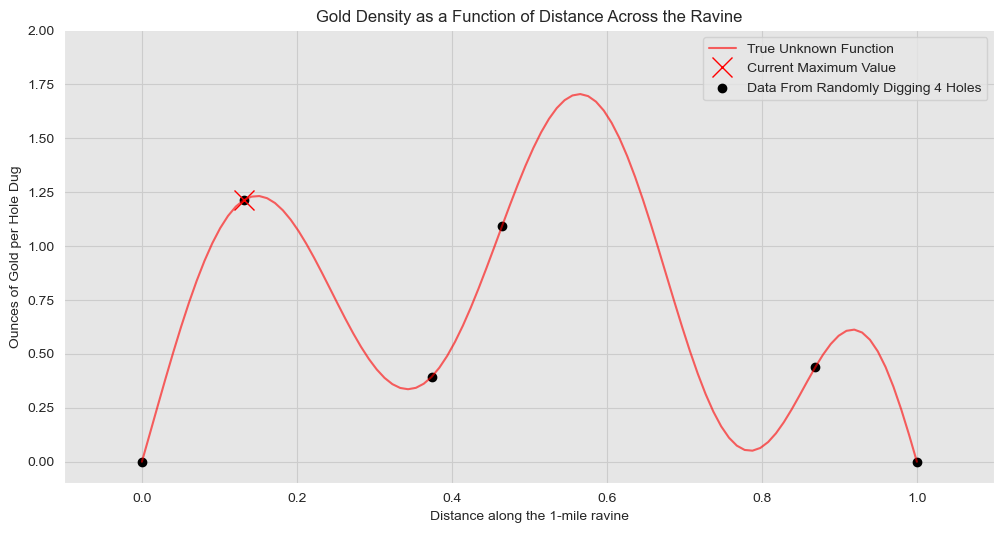

In [12]:
import random
random.seed(9)

N = np.linspace(start=0, stop=n-1, num=n)
choice = random.choices(N, k = 4)

lst_f = [0]
lst_x = [0]

for i in choice:
    lst_f.append(f_x[int(i)])
    lst_x.append(x_original[int(i)])

lst_f.append(0)
lst_x.append(1.0)

plt.scatter(lst_x,lst_f, color = 'black', label = "Data From Randomly Digging 4 Holes")
plt.plot(x_original,f_x, color = "red", alpha = 0.6, label="True Unknown Function")

plt.axis([-0.1, 1.1, -0.1, 2])
plt.ylabel('Ounces of Gold per Hole Dug')
plt.xlabel('Distance along the 1-mile ravine')
plt.title('Gold Density as a Function of Distance Across the Ravine')
plt.plot(lst_x[lst_f.index(max(lst_f))],lst_f[lst_f.index(max(lst_f))],'rx', 
         markersize=15, label = 'Current Maximum Value') 
plt.legend(loc = 'upper right')
plt.show()

Brief Recap of Results:

At this point, you are able to seperate yourself from the other miners that came before you. By looking at the graph of the holes that you have dug (you cannot see the red line) one might assume that you should search in the area where you discovered the most gold (where x=0.13 miles deep into the ravine), about 1.25 ounces per hole dug.

However, since you are not a normal miner, you decide to balance this idea of exploring and exploiting by constructing a Gaussian Process. Doing this will allow you to find areas that have the potential to contain even more ounces of gold per hole dug than your current best hole. By doing this you can be sure you are mining in the correct area and getting the most gold as possible.

Step 2:
    
    Build out the Gaussian Process

In [42]:
def kernel_function(x, y, sigma_f=1, l=1):
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel


import itertools

x = np.array(lst_x)
x_star = np.linspace(0,1,n)
l = 1
sigma_f = 1


def compute_cov_matrices(x, x_star, sigma_f=1, l=1):
    n = x.shape[0]
    n_star = x_star.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

In [43]:
sigma_n = 0
d = 1
y = np.array(lst_f)


def compute_gpr_parameters(K, K_star2, K_star, sigma_n):
    n = K.shape[0]
    # Mean.
    f_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y.reshape([n, d])))
    # Covariance.
    cov_f_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (f_bar_star, cov_f_star)
# Compute posterior mean and covariance. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

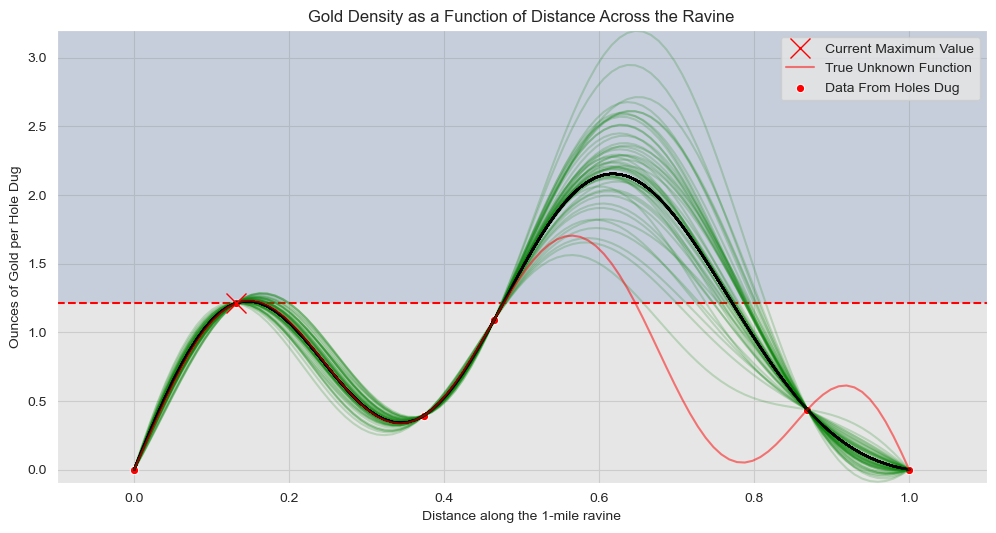

In [44]:
l = 0.2
sigma_f = 1
sigma_n = 0


x = np.array(lst_x)
x_star = np.linspace(0,1,100)

K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots()

for i in range(0, 50):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    m_star = f_bar_star.squeeze()
    # Plot function.
    sns.lineplot(x=x_star, y=m_star, color='black', alpha=1, ax=ax);
    sns.lineplot(x=x_star, y=z_star, color='green', alpha=0.2, ax=ax);
    
sns.scatterplot(x=x, y=y, color = 'red', label='Data From Holes Dug', ax=ax);
plt.hlines(y=max(lst_f), xmin=-0.1,xmax=1.1, linestyles='dashed', colors = 'red')
plt.axhspan(max(lst_f),3.2, alpha = 0.2)
plt.plot(lst_x[lst_f.index(max(lst_f))],lst_f[lst_f.index(max(lst_f))],
         'rx', markersize=15, label = 'Current Maximum Value') 
plt.plot(x_original,f_x, color = "red", alpha = 0.5, label="True Unknown Function")
                 
plt.ylabel('Ounces of Gold per Hole Dug')
plt.xlabel('Distance along the 1-mile ravine')
plt.title('Gold Density as a Function of Distance Across the Ravine')

plt.axis([-0.1, 1.1, -0.1, 3.2])
plt.legend(loc = 'upper right')

Result:

Based off of your 4 randomly dug holes (a months worth of work) you constuct the graph above. You see the area where you are most likely to find a higher density of gold per hole dug lies roughly at x=0.62 miles deep into the ravine. This is where you should dig next.

KEY: 

The key here is to not just explore at where you found the most gold initially (when x=0.13), but rather areas that have the potential to contain the most gold. By doing this you can either rule out an area that has less gold, or you can improve your searching location if it has more gold. We can see the Gaussain Process has a larger confidence interval at locations where the nearest known data points are further away, and as we get closer to known points that confidence interval narrows out as it becomes more certain.

Step 3:
    
    We "dig" a new hole at the location roughly 0.62 miles into the ravine, since the Gaussian Process has shown this is a spot that has the potential to have the greatest maximum gold density of the entire ravine. Once we have this new data point, we can run the GP again and have an even more accurate model since with each data point the GP is able to learn.

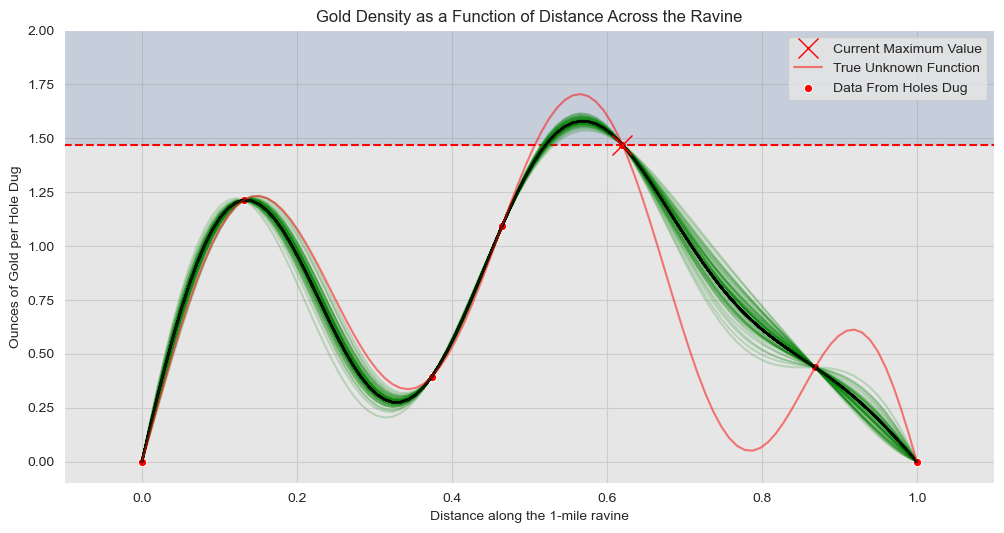

In [45]:
l = 0.2
sigma_f = 1
sigma_n = 0

y = np.array(lst_f)
x = np.array(lst_x)

x = np.append(x,(0.62))
y = np.append(y,f(0.62))

x = x
x_star = np.linspace(0,1,100)

K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots()

for i in range(0, 50):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    m_star = f_bar_star.squeeze()
    # Plot function.
    sns.lineplot(x=x_star, y=m_star, color='black', alpha=1, ax=ax);
    sns.lineplot(x=x_star, y=z_star, color='green', alpha=0.2, ax=ax);

sns.scatterplot(x=x, y=y, color = 'red', label='Data From Holes Dug', ax=ax);
plt.hlines(y=max(y), xmin=-0.1,xmax=1.1, linestyles='dashed', colors = 'red')
plt.axhspan(max(y),2, alpha = 0.2)
plt.axis([-0.1, 1.1, -0.1, 2])
plt.plot(x[np.where(y == max(y))],y[np.where(y == max(y))],
         'rx', markersize=15, label = 'Current Maximum Value') 
plt.plot(x_original,f_x, color = "red", alpha = 0.5, label="True Unknown Function")

plt.ylabel('Ounces of Gold per Hole Dug')
plt.xlabel('Distance along the 1-mile ravine')
plt.title('Gold Density as a Function of Distance Across the Ravine')

plt.legend(loc = 'upper right')
plt.show()

Result:

Now you have found an area of the ravine with an even higher gold density per hole dug than your previous maximum! You can repeat this process as many times as you would like until you feel confident that you are searching in the right spot. The next most logical place to search is at x=0.57 miles into the ravine. Since it has the potential to contain a maximum that is greater than our current spot.

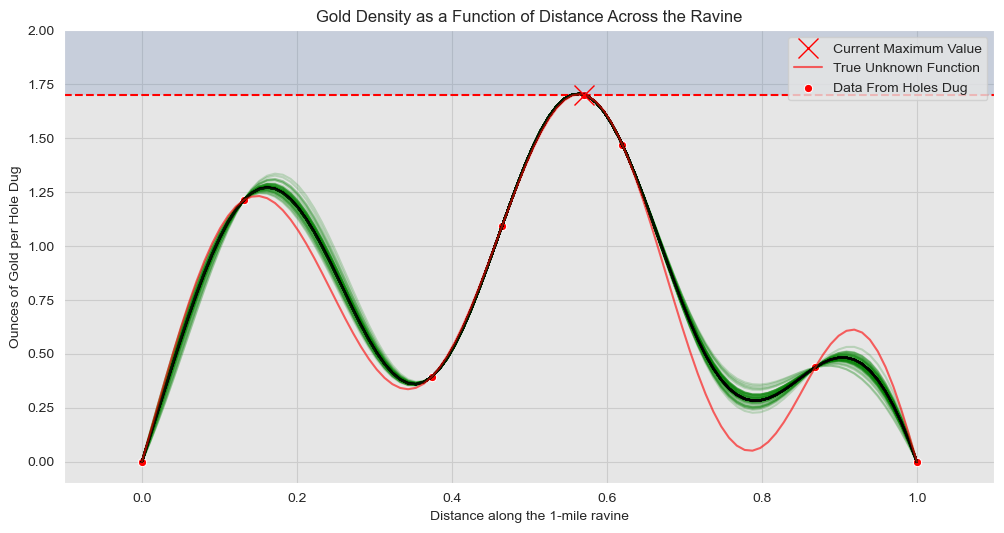

In [46]:
l = 0.2
sigma_f = 1
sigma_n = 0

x = np.array(lst_x)
y = np.array(lst_f)

x = np.append(x,(0.62)) #we can do this since we dug here and now know the true gold density value at this spot
y = np.append(y,f(0.62)) #we can do this since we dug here and now know the true gold density value at this spot

x = np.append(x,(0.57))
y = np.append(y,f(0.57))

x = x
x_star = np.linspace(0,1,100)

K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots()

for i in range(0, 50):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    m_star = f_bar_star.squeeze()
    # Plot function.
    sns.lineplot(x=x_star, y=m_star, color='black', alpha=1, ax=ax);
    sns.lineplot(x=x_star, y=z_star, color='green', alpha=0.2, ax=ax);

sns.scatterplot(x=x, y=y, color = 'red', label='Data From Holes Dug', ax=ax);
plt.hlines(y=max(y), xmin=-0.1,xmax=1.1, linestyles='dashed', colors = 'red')
plt.axhspan(max(y),2, alpha = 0.2)
plt.axis([-0.1, 1.1, -0.1, 2])
plt.plot(x[np.where(y == max(y))],y[np.where(y == max(y))],'rx', markersize=15, label = 'Current Maximum Value') 
plt.plot(x_original,f_x, color = "red", alpha = 0.6, label="True Unknown Function")

plt.ylabel('Ounces of Gold per Hole Dug')
plt.xlabel('Distance along the 1-mile ravine')
plt.title('Gold Density as a Function of Distance Across the Ravine')

plt.legend(loc = 'upper right')
plt.show()

Result:

    Since you no longer have an area above our maximum data point where our confidence interval falls into, you can be fairly confident that you have found the best place to stop searching for gold and start mining for it! Here you have found the maximum of the function with the fewest number of steps possible, assuming that you don't already know where the gold is hidden.

    Digging in this area will provide you with 1.71 ounces of gold per hole that you dig, and after only 5 holes dug, and just over a month of work, you have found the perfect spot to start your mine and become a millionaire.

    What makes the Gaussian Process so unique is that it does a really great job of capitalizing on the "Exploring v Exploiting" Problem when there is a cost for searching. In this case the cost is that you have to dig more holes which takes more time and energy, but this is a true concern for many companies in the present day such as oil companies that need to decide where to set up their wells. The faster we can find the maximum of our function, the faster we can optimize the system, and the more time and money we can save.